In [21]:
# import numpy - array processing library
import numpy as np 

# pytorch imports:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# pytorch functionality for image datasets
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

def show_image_grid(X, y=None, y_pred=None, title=None, nrow=6, ncol=4, **kwargs):
    max_num = nrow*ncol
    X = X[:max_num]
    if len(X) < max_num:
        ncol = len(X) // nrow + 1
    if isinstance(X, np.ndarray):
        X = th.from_numpy(X)
    if X.dim() != 4:
        X = X[:, None]

    plt.figure(title, figsize=(2*nrow, 2*ncol + (0 if y is None else 1)))
    if title:
        plt.title(title)
        
    if isinstance(y, th.Tensor):
        y = y.numpy()
        
    for i, Xi in enumerate(X):
        plt.subplot(ncol, nrow, i+1)
        img = Xi.numpy().transpose((1, 2, 0))
        if img.shape[2] == 1:
            img = img[..., 0]
        plt.imshow(img, cmap="gray")

        title = ""
        if y is not None:
          title += str(int(y[i]))
        if y_pred is not None:
          title += "/" + str(int(y_pred[i]))
        if len(title) > 0: 
          plt.title(title)

        plt.axis('off')
    
    plt.axis('off')


batch_size = 128
train_data = datasets.MNIST(root='./data', train=True, 
                            download=True, transform=transforms.ToTensor())
train_loader = th.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_data = datasets.MNIST(root='./data', train=False, 
                            download=True, transform=transforms.ToTensor())
valid_loader = th.utils.data.DataLoader(valid_data, shuffle=False, batch_size=batch_size)


def forward(X, weight, bias):
    return X.view(-1, 28*28) @ weight + bias

lr = 0.1

# initialize weights
weight = th.zeros((28*28, 10), requires_grad=True)
nn.init.kaiming_uniform_(weight, mode='fan_out')
bias = th.zeros(10, requires_grad=True)

for epoch in range(5):
    # train on mini batches
    losses = []
    for X, y in train_loader:
        output = forward(X, weight, bias)

        # compute loss
        loss = F.cross_entropy(output, y)
        losses.append(loss.item())

        # backpropagation
        loss.backward()

        # gradient descent update
        with th.no_grad():
          weight -= lr * weight.grad
          bias -= lr * bias.grad
          weight.grad.zero_()
          bias.grad.zero_()
            
    # measure accuracy on the validation set
    with th.no_grad():
      num_correct = 0
      for X, y in valid_loader:
        num_correct += (forward(X, weight, bias).argmax(1) == y).sum().item()
      acc = 100 * num_correct / len(valid_data)

    print(f"epoch {epoch: 3d} | loss {np.mean(losses):8.5f} | accuracy: {acc: 4.2f}%")


epoch   0 | loss  0.58078 | accuracy:  89.92%
epoch   1 | loss  0.37546 | accuracy:  90.89%
epoch   2 | loss  0.34312 | accuracy:  91.37%
epoch   3 | loss  0.32651 | accuracy:  91.46%
epoch   4 | loss  0.31588 | accuracy:  91.75%


Visualizing the wrong predictions on the validation set:

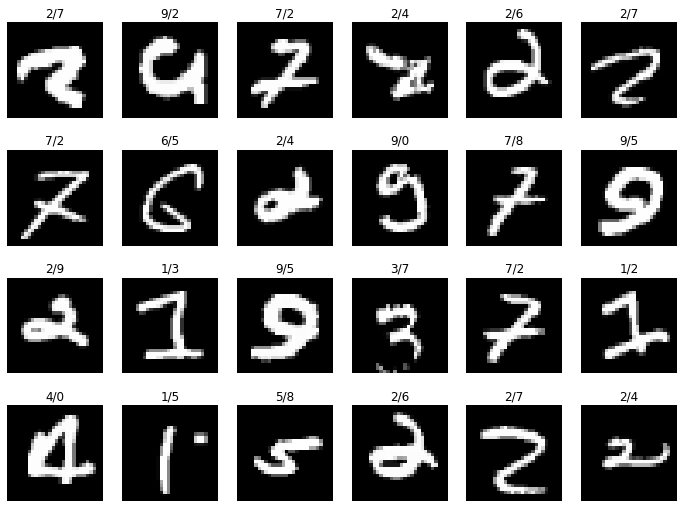

In [43]:
X_wrong = []
y_wrong_label = []
y_wrong_pred = []
loss = []

for X, y_label in valid_loader:
  output = forward(X, weight, bias)
  y_pred = output.argmax(1)     # predicted labels
  is_wrong = y_pred != y_label  # boolean tensor

  X_wrong.append(X[is_wrong])
  y_wrong_label.append(y_label[is_wrong])
  y_wrong_pred.append(y_pred[is_wrong])

  # compute loss for each wrong image
  loss.append(F.cross_entropy(output[is_wrong], y_label[is_wrong], reduction='none'))

X_wrong = th.cat(X_wrong)
y_wrong_label = th.cat(y_wrong_label)
y_wrong_pred = th.cat(y_wrong_pred)

# sort by highest loss first
order = th.cat(loss).argsort(descending=True)

show_image_grid(
    X_wrong[order], y_wrong_label[order], y_wrong_pred[order],
)